### Importing Data and EDA

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report
import xgboost as xgb

data = pd.read_parquet('data/data.parquet')
labels = pd.read_csv('data/labels.csv')


In [283]:
data.describe()

,MeasurementId,Pressure
count,1.846636e+07,1.846636e+07
mean,3.398397e+03,3.338926e-01
std,3.019365e+03,4.862787e-01
min,-1.000000e+00,0.000000e+00
25%,-1.000000e+00,0.000000e+00
50%,3.179000e+03,0.000000e+00
75%,6.277000e+03,7.017707e-01
max,8.834000e+03,6.774464e+00


In [284]:
# Group by MachineId and MeasurementId and count the number of pressure measurements
pressure_counts = data.groupby(['MachineId', 'MeasurementId']).size().reset_index(name='Pressure_Count')

# Display the resulting DataFrame
print(pressure_counts)


      MachineId  MeasurementId  Pressure_Count
0         0_0_0             -1          101711
1         0_0_0              0             368
2         0_0_0            215             732
3         0_0_0            237             589
4         0_0_0            353             349
...         ...            ...             ...
27380     9_5_3           4253             337
27381     9_5_3           4254             478
27382     9_5_3           4255             436
27383     9_5_3           4256             549
27384     9_5_3           4257             380

[27385 rows x 3 columns]


In [285]:
print(labels.groupby([ 'PumpFailed', 'SlowStart', 'SlowEnd']).size().reset_index(name='Count'))

   PumpFailed  SlowStart  SlowEnd  Count
0       False      False    False  12269
1       False      False     True   3820
2       False       True    False   1050
3       False       True     True      1
4        True      False    False   2158
5        True      False     True      2


In [286]:
duplicates = data[data['MeasurementId'] != -1].duplicated(subset=['MachineId', 'MeasurementId', 'Pressure'])
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}")

num_bad_values = data[data['Pressure'] < 0]['Pressure'].count()
print(f"Number of bad values: {num_bad_values}")

num_null_values = data.isnull().sum()
print(f"Number of null values: {num_null_values}")

num_null_values_labels = labels.isnull().sum()
print(f"Number of null values: {num_null_values_labels}")


Number of duplicate rows: 9488653
Number of bad values: 0
Number of null values: MachineId        0
MeasurementId    0
Pressure         0
dtype: int64
Number of null values: MachineId           0
MeasurementId       0
PumpFailed        485
SlowStart        8085
SlowEnd          8085
dtype: int64


Suspicious MeasurementId = -1. Probably not correct data. Data contain a lot of duplicated values => to check if it's ok. 
Number of time datapoint in each measurement is different => to check why. 
Label data have some nulls -> probably to drop all of them.

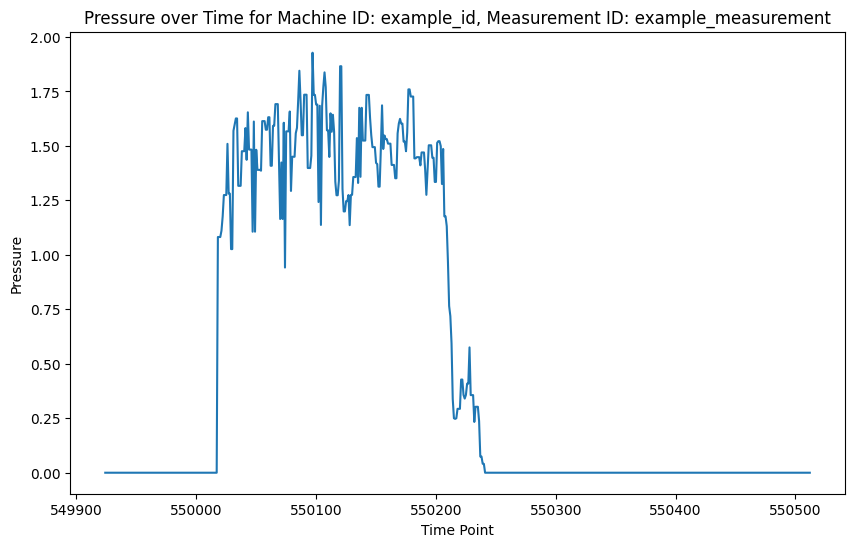

In [287]:
# Example: Plotting pressure for a specific MachineId and MeasurementId
selected_cycle = data[(data['MachineId'] == '0_0_0') & (data['MeasurementId'] == 237)]

plt.figure(figsize=(10, 6))
plt.plot(selected_cycle['Pressure'])
plt.title('Pressure over Time for Machine ID: example_id, Measurement ID: example_measurement')
plt.xlabel('Time Point')
plt.ylabel('Pressure')
plt.show()


Duplicates are not a problem since it's just a start and end of cycle. 
Each MachineId and MeasurementId should have time point starting with 0. 

In [2]:
# Function to create a sequential index for each group
def create_sequential_index(group):
    return pd.Series(range(len(group)), index=group.index)

# Apply the function to each group
data['SequentialIndex'] = data.groupby(['MachineId', 'MeasurementId']).apply(create_sequential_index).reset_index(level=[0, 1], drop=True)

# Display the DataFrame
print(data.head())
print(data['SequentialIndex'].value_counts().sort_index())

  MachineId  MeasurementId  Pressure  SequentialIndex
0     0_0_0              0       0.0                0
1     0_0_0              0       0.0                1
2     0_0_0              0       0.0                2
3     0_0_0              0       0.0                3
4     0_0_0              0       0.0                4
0         27385
1         27385
2         27385
3         27385
4         27385
          ...  
185471        1
185472        1
185473        1
185474        1
185475        1
Name: SequentialIndex, Length: 185476, dtype: int64


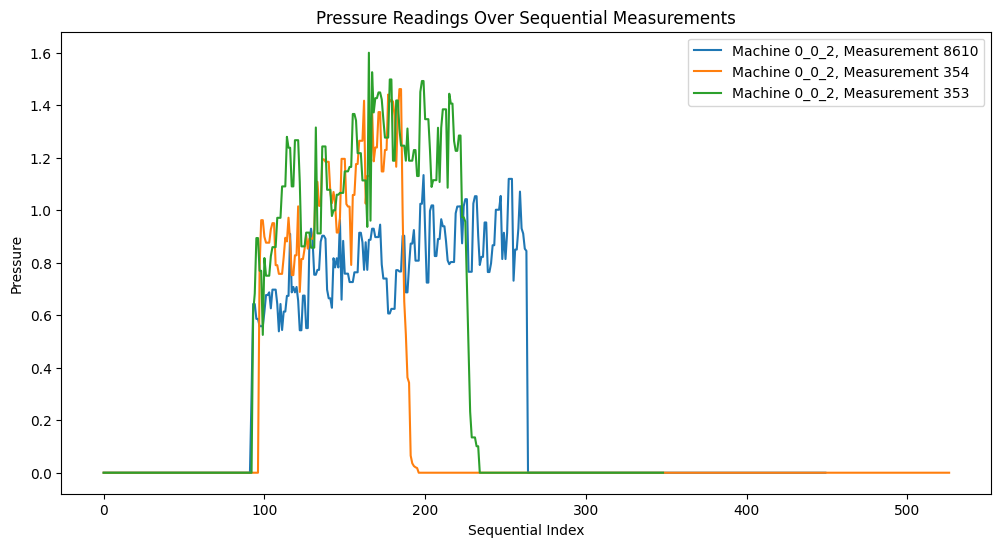

In [289]:
cycles_to_plot = [('0_0_2', 8610), ('0_0_2', 354), ('0_0_2',353)]  # Replace with your specific MachineId and MeasurementId pairs

plt.figure(figsize=(12, 6))

# Plot each cycle
for machine_id, measurement_id in cycles_to_plot:
    cycle_data = data[(data['MachineId'] == machine_id) & (data['MeasurementId'] == measurement_id)]
    plt.plot(cycle_data['SequentialIndex'], cycle_data['Pressure'], label=f'Machine {machine_id}, Measurement {measurement_id}')

plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Pressure Readings Over Sequential Measurements')
plt.legend()
plt.show()

### Mergind dataframes together

In [3]:
df = pd.merge(data, labels, on=['MachineId', 'MeasurementId'])
df= df.dropna()

In [124]:

merged_df = pd.merge(data, labels, on=['MachineId', 'MeasurementId'], how='outer')
# Check for rows where label information is missing
missing_labels = merged_df[merged_df['Pressure'].isnull()]
# Number of entries from labels that weren't merged
num_missing_labels = missing_labels.shape[0]

print(f"Number of entries from labels that weren't merged: {num_missing_labels}")


Number of entries from labels that weren't merged: 0


In [291]:
#All data statistics
print(df.groupby(['PumpFailed', 'SlowStart', 'SlowEnd'])['Pressure'].agg(['mean', 'median', 'max', 'min']).reset_index())


   PumpFailed  SlowStart  SlowEnd      mean  median       max  min
0       False      False    False  0.379748     0.0  4.636766  0.0
1       False      False     True  0.313899     0.0  5.778499  0.0
2       False       True    False  0.330472     0.0  3.298364  0.0
3       False       True     True  0.201592     0.0  1.160819  0.0
4        True      False    False  0.331242     0.0  3.051502  0.0
5        True      False     True  0.206909     0.0  1.788187  0.0


SlowEnd and SlowStart seems to have impact on the pressure mean. Still not sure if it has impact on the mean of the Failed Pump. 

I don't like the fact that data are not the same size. Also there is some data with multiple cycles - can take first one, but question is if result is for the first cycle.

Two ideas:
 * to cut data after some treshhold
 * create some time_ids starting with pressure rising and ending with pressure go down to 0 for the first time. 

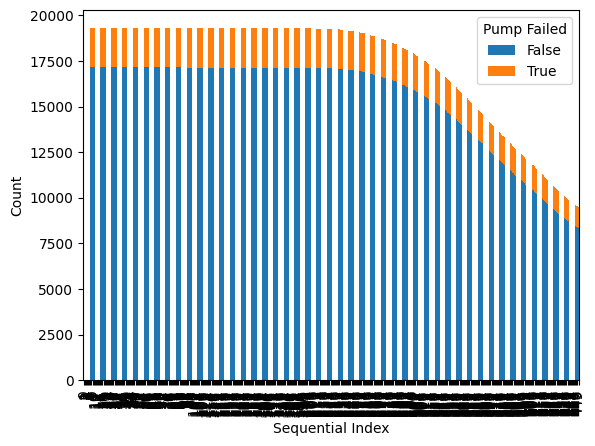

In [292]:
grouped_counts = df.groupby(['SequentialIndex', 'PumpFailed']).size()

# Convert the Series to a DataFrame for easier filtering
grouped_counts_df = grouped_counts.reset_index(name='Count')

# Filter to retain only SequentialIndex values less than 300
filtered_counts = grouped_counts_df[grouped_counts_df['SequentialIndex'] < 450]

# Create a pivot table for plotting
pivot_counts = filtered_counts.pivot(index='SequentialIndex', columns='PumpFailed', values='Count')

# Plot the distribution of counts for these SequentialIndex values
pivot_counts.plot(kind='bar', stacked=True)
plt.xlabel('Sequential Index')
plt.ylabel('Count')
plt.legend(title='Pump Failed')
plt.show()

In [293]:
print(df[(df['SequentialIndex'] <450) & (df['SequentialIndex'] > 80)].groupby(['PumpFailed', 'SlowStart', 'SlowEnd'])['Pressure'].agg(['mean', 'median', 'max', 'min', 'std']).reset_index())


   PumpFailed  SlowStart  SlowEnd      mean    median       max  min       std
0       False      False    False  0.562705  0.606145  4.636766  0.0  0.548917
1       False      False     True  0.476764  0.209713  4.846856  0.0  0.565716
2       False       True    False  0.489722  0.492567  3.298364  0.0  0.438521
3       False       True     True  0.275345  0.000000  1.160819  0.0  0.347348
4        True      False    False  0.498357  0.493942  3.051502  0.0  0.497173
5        True      False     True  0.395710  0.000000  1.788187  0.0  0.547342


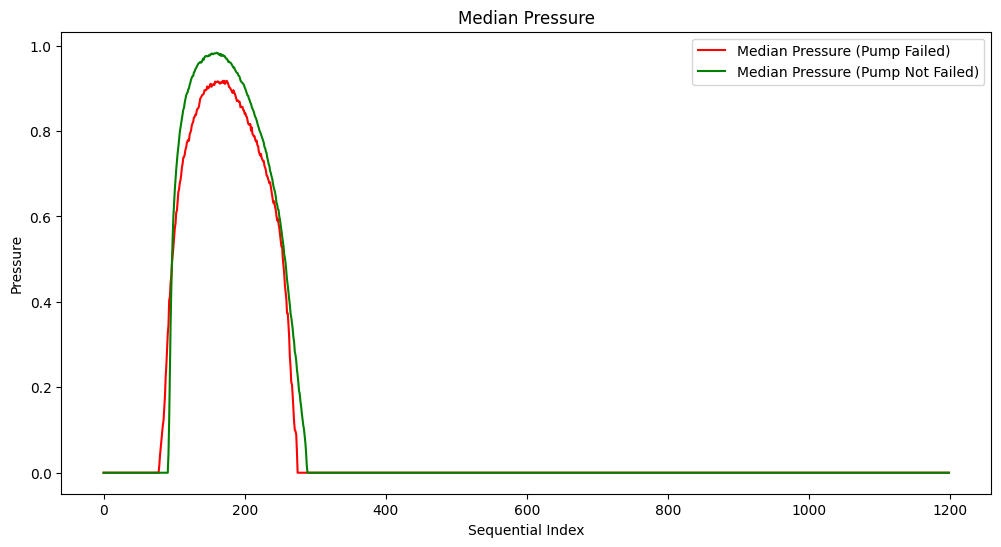

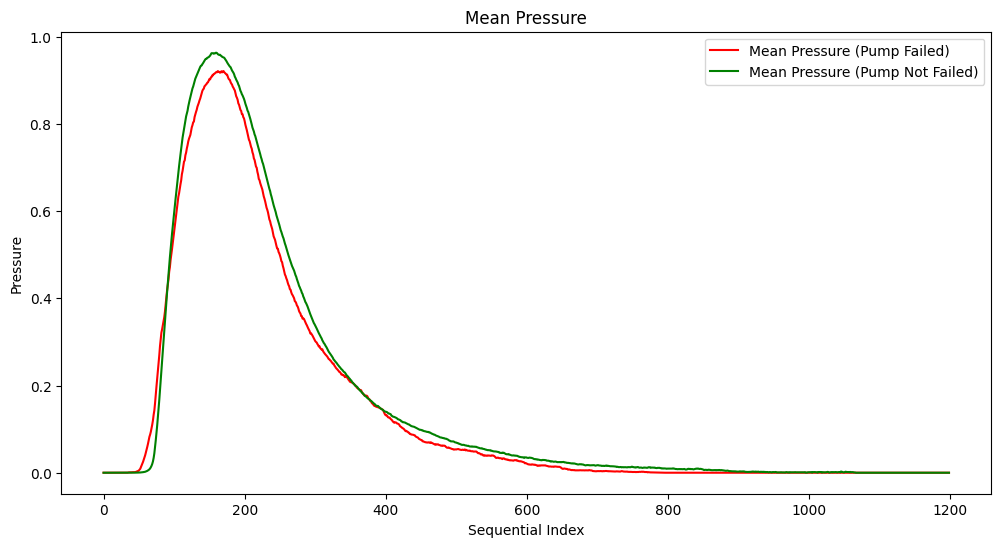

In [294]:
pressure_stats_seq_index = df.groupby(['SequentialIndex', 'PumpFailed'])['Pressure'].agg(['mean', 'median']).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Separate the data
failed = pressure_stats_seq_index[pressure_stats_seq_index['PumpFailed']]
not_failed = pressure_stats_seq_index[~pressure_stats_seq_index['PumpFailed']]

# Plot mean pressure for PumpFailed = True and False
plt.plot(failed['SequentialIndex'], failed['median'], label='Median Pressure (Pump Failed)', color='red')
plt.plot(not_failed['SequentialIndex'], not_failed['median'], label='Median Pressure (Pump Not Failed)', color='green')

plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Median Pressure')
plt.legend()
plt.show()


# Plotting
plt.figure(figsize=(12, 6))

# Separate the data
failed = pressure_stats_seq_index[pressure_stats_seq_index['PumpFailed']]
not_failed = pressure_stats_seq_index[~pressure_stats_seq_index['PumpFailed']]

# Plot mean pressure for PumpFailed = True and False
plt.plot(failed['SequentialIndex'], failed['mean'], label='Mean Pressure (Pump Failed)', color='red')
plt.plot(not_failed['SequentialIndex'], not_failed['mean'], label='Mean Pressure (Pump Not Failed)', color='green')

plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Mean Pressure')
plt.legend()
plt.show()

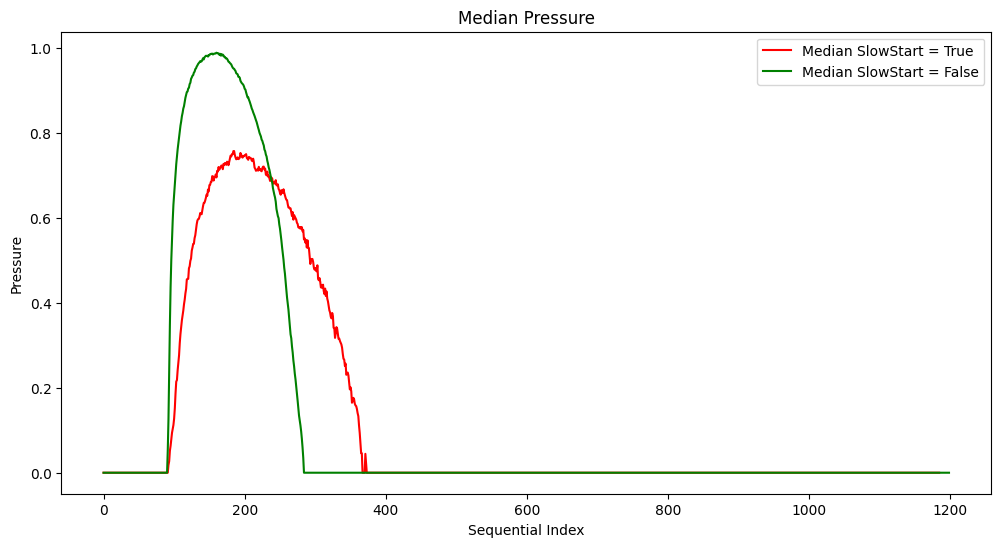

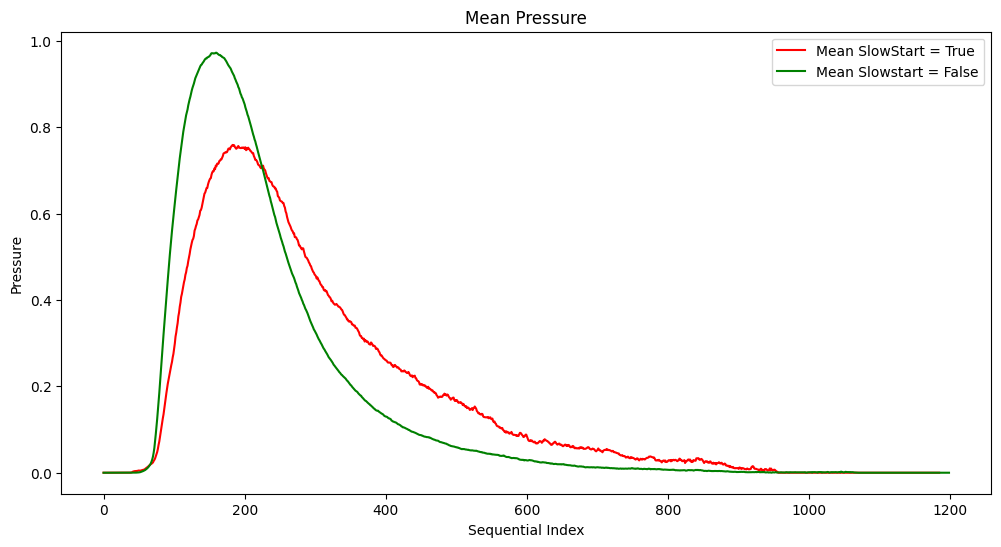

In [295]:
#Slow start 
pressure_stats_seq_index = df.groupby(['SequentialIndex', 'SlowStart'])['Pressure'].agg(['mean', 'median']).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Separate the data
failed = pressure_stats_seq_index[pressure_stats_seq_index['SlowStart']]
not_failed = pressure_stats_seq_index[~pressure_stats_seq_index['SlowStart']]

# Plot mean pressure for PumpFailed = True and False
plt.plot(failed['SequentialIndex'], failed['median'], label='Median SlowStart = True', color='red')
plt.plot(not_failed['SequentialIndex'], not_failed['median'], label='Median SlowStart = False', color='green')

plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Median Pressure')
plt.legend()
plt.show()


# Plotting
plt.figure(figsize=(12, 6))

# Separate the data
failed = pressure_stats_seq_index[pressure_stats_seq_index['SlowStart']]
not_failed = pressure_stats_seq_index[~pressure_stats_seq_index['SlowStart']]

# Plot mean pressure for PumpFailed = True and False
plt.plot(failed['SequentialIndex'], failed['mean'], label='Mean SlowStart = True', color='red')
plt.plot(not_failed['SequentialIndex'], not_failed['mean'], label='Mean Slowstart = False', color='green')

plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Mean Pressure')
plt.legend()
plt.show()


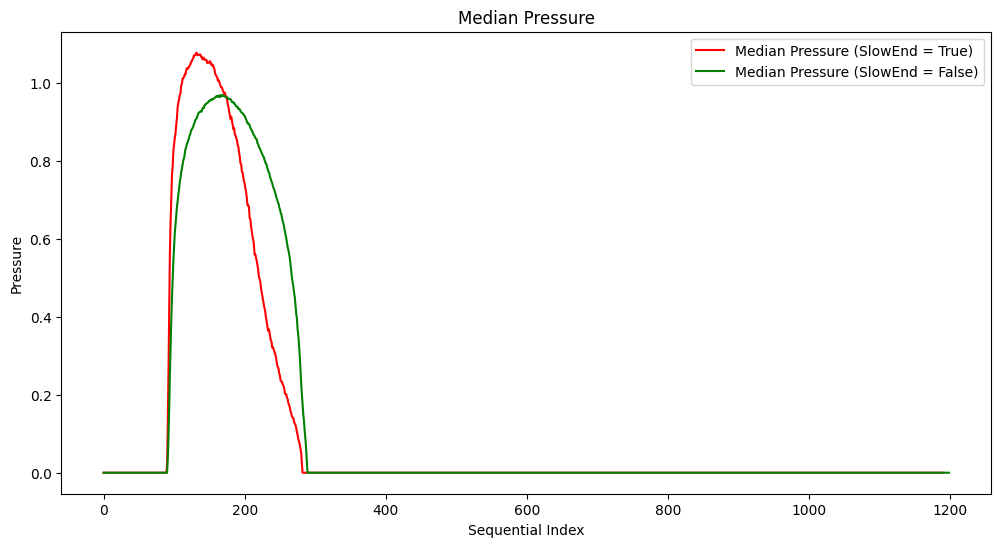

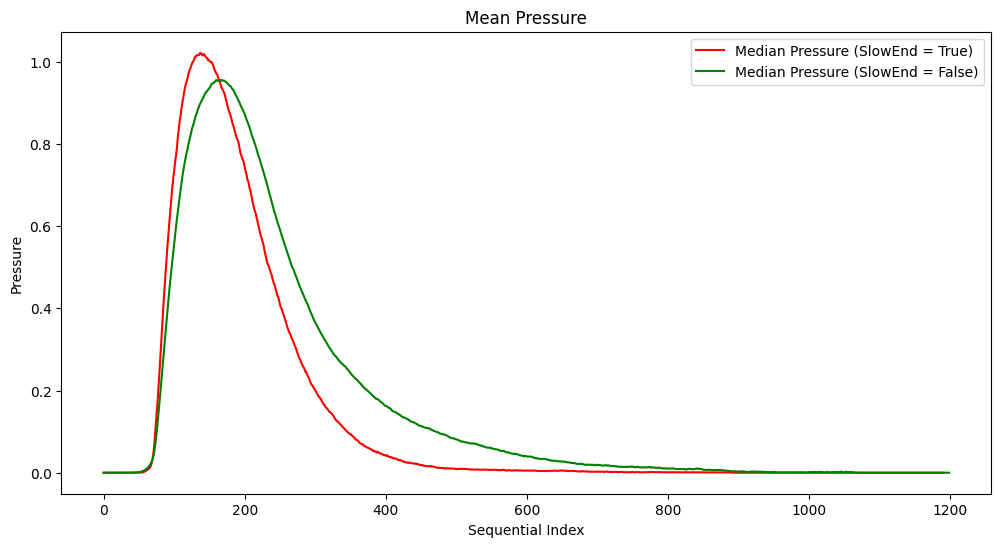

In [296]:
pressure_stats_seq_index = df.groupby(['SequentialIndex', 'SlowEnd'])['Pressure'].agg(['mean', 'median']).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Separate the data
failed = pressure_stats_seq_index[pressure_stats_seq_index['SlowEnd']]
not_failed = pressure_stats_seq_index[~pressure_stats_seq_index['SlowEnd']]

# Plot mean pressure for PumpFailed = True and False
plt.plot(failed['SequentialIndex'], failed['median'], label='Median Pressure (SlowEnd = True)', color='red')
plt.plot(not_failed['SequentialIndex'], not_failed['median'], label='Median Pressure (SlowEnd = False)', color='green')

plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Median Pressure')
plt.legend()
plt.show()


# Plotting
plt.figure(figsize=(12, 6))

# Separate the data
failed = pressure_stats_seq_index[pressure_stats_seq_index['SlowEnd']]
not_failed = pressure_stats_seq_index[~pressure_stats_seq_index['SlowEnd']]

# Plot mean pressure for PumpFailed = True and False
plt.plot(failed['SequentialIndex'], failed['mean'], label='Median Pressure (SlowEnd = True)', color='red')
plt.plot(not_failed['SequentialIndex'], not_failed['mean'], label='Median Pressure (SlowEnd = False)', color='green')

plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Mean Pressure')
plt.legend()
plt.show()


Need more metrics to analize the data. 

Ideas:
* Difference between pressure 
* Standard deviation
* Normilize data with max and calculate difference (if it makes sense)

In [4]:
# Calculate the difference in pressure between consecutive measurements
df['Pressure_Diff'] = abs(df.groupby(['MachineId', 'MeasurementId'])['Pressure'].diff())
df['Pressure_Diff'] = df['Pressure_Diff'].fillna(0)

# Normalised difference
df['Norm_Pressure'] = df.groupby(['MachineId', 'MeasurementId'])['Pressure'].transform(lambda x: x / x.max())
df['Norm_Pressure_Diff'] = abs(df.groupby(['MachineId', 'MeasurementId'])['Norm_Pressure'].diff())
df['Norm_Pressure_Diff'] = df['Pressure_Diff'].fillna(0)


# Rolling difference with x last timestamps
rolling_means = df.groupby(['MachineId', 'MeasurementId'])['Norm_Pressure'].rolling(window=10, min_periods=1).mean().reset_index(level=[0,1], drop=True)
df['Rolling_Mean_Pressure'] = rolling_means
df['Pressure_Rolling_Diff'] = abs(df['Norm_Pressure'] - df['Rolling_Mean_Pressure'])




In [298]:
print(df.groupby(['PumpFailed', 'SlowStart', 'SlowEnd'])['Pressure_Diff'].agg(['mean', 'median', 'max', 'min', 'std']).reset_index())

print(df.groupby(['PumpFailed', 'SlowStart', 'SlowEnd'])['Norm_Pressure_Diff'].agg(['mean', 'median', 'max', 'min', 'std']).reset_index())


   PumpFailed  SlowStart  SlowEnd      mean  median       max  min       std
0       False      False    False  0.031290     0.0  3.861522  0.0  0.077798
1       False      False     True  0.029429     0.0  3.740337  0.0  0.078031
2       False       True    False  0.026243     0.0  2.835419  0.0  0.055484
3       False       True     True  0.038870     0.0  1.052632  0.0  0.104949
4        True      False    False  0.025771     0.0  2.984970  0.0  0.061965
5        True      False     True  0.020519     0.0  0.660896  0.0  0.061578
   PumpFailed  SlowStart  SlowEnd      mean  median       max  min       std
0       False      False    False  0.031290     0.0  3.861522  0.0  0.077798
1       False      False     True  0.029429     0.0  3.740337  0.0  0.078031
2       False       True    False  0.026243     0.0  2.835419  0.0  0.055484
3       False       True     True  0.038870     0.0  1.052632  0.0  0.104949
4        True      False    False  0.025771     0.0  2.984970  0.0  0.061965

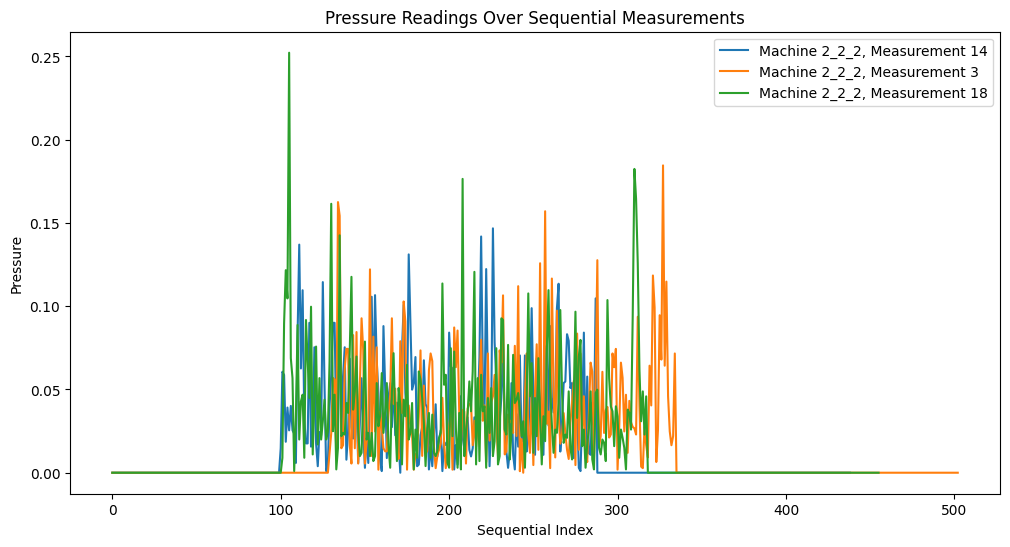

In [299]:
cycles_to_plot = [('2_2_2', 14), ('2_2_2', 3), ('2_2_2',18)]  # Replace with your specific MachineId and MeasurementId pairs

plt.figure(figsize=(12, 6))

# Plot each cycle
for machine_id, measurement_id in cycles_to_plot:
    cycle_data = df[(df['MachineId'] == machine_id) & (df['MeasurementId'] == measurement_id)]
    plt.plot(cycle_data['SequentialIndex'], cycle_data['Norm_Pressure_Diff'], label=f'Machine {machine_id}, Measurement {measurement_id}')

plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Pressure Readings Over Sequential Measurements')
plt.legend()
plt.show()

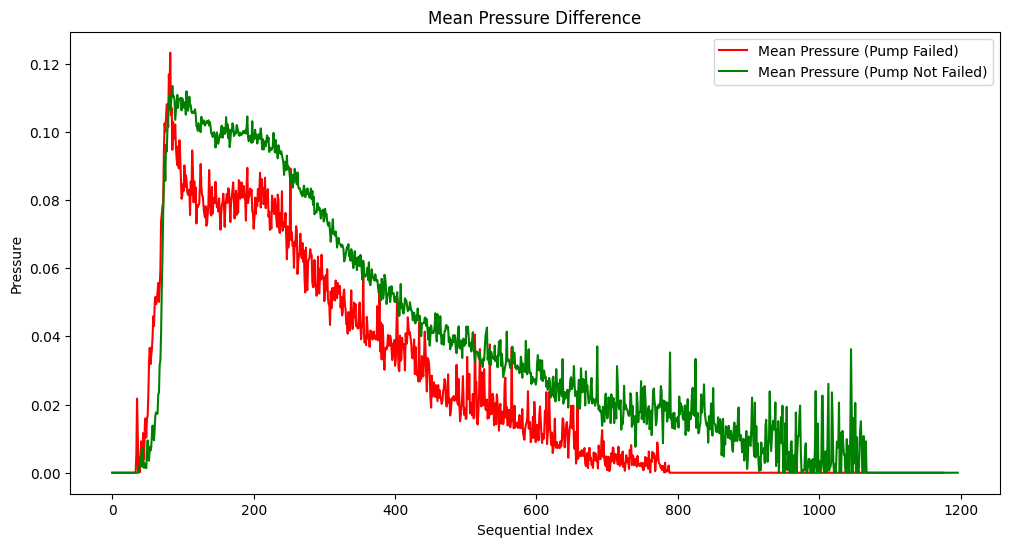

In [300]:
pressure_stats_seq_index = df.groupby(['SequentialIndex', 'PumpFailed'])['Norm_Pressure_Diff'].agg(['std']).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Separate the data
failed = pressure_stats_seq_index[pressure_stats_seq_index['PumpFailed']]
not_failed = pressure_stats_seq_index[~pressure_stats_seq_index['PumpFailed']]

# Plot mean pressure for PumpFailed = True and False
plt.plot(failed['SequentialIndex'], failed['std'], label='Mean Pressure (Pump Failed)', color='red')
plt.plot(not_failed['SequentialIndex'], not_failed['std'], label='Mean Pressure (Pump Not Failed)', color='green')

plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Mean Pressure Difference')
plt.legend()
plt.show()

### Reindexing data
Idea is to reindex data so cycle starts with pressure raise and ended once pump pressure is 0.

In [5]:
def reindex_cycle(group):
    # Find the start of the cycle (first non-zero after a zero)
    start_condition = (group['Pressure'].shift(1) == 0) & (group['Pressure'] > 0)
    start_indices = group[start_condition].index
    start_index = start_indices[0] if not start_indices.empty else None

    if start_index is not None:
        # Find the end of the cycle (next zero after the start)
        end_condition = group.index > start_index
        end_indices = group[end_condition & (group['Pressure'] == 0)].index
        end_index = end_indices[0] if not end_indices.empty else None

        # If an end is not found, use the last index in the group
        if end_index is None:
            end_index = group.index.max()
    else:
        # If no start is found, return the group as is
        return group

    # Reindex the cycle
    group = group.loc[start_index:end_index]
    group['NewSequentialIndex'] = range(1, len(group) + 1)

    return group

# Apply the function to each MachineId and MeasurementId group
df_ind = df.groupby(['MachineId', 'MeasurementId']).apply(reindex_cycle).reset_index(drop=True)


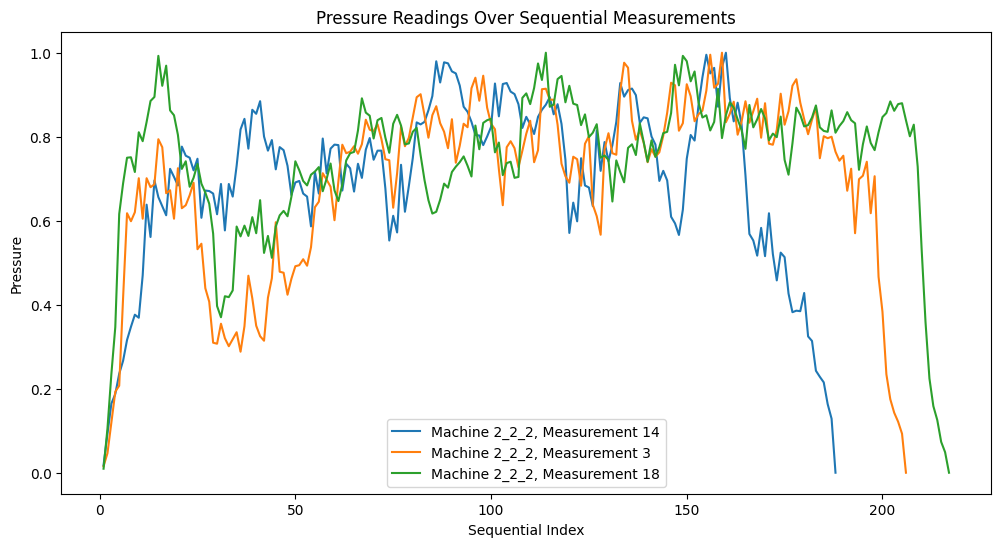

In [26]:
cycles_to_plot = [('2_2_2', 14), ('2_2_2', 3), ('2_2_2',18)]  # Replace with your specific MachineId and MeasurementId pairs

plt.figure(figsize=(12, 6))

# Plot each cycle
for machine_id, measurement_id in cycles_to_plot:
    cycle_data = df_ind[(df_ind['MachineId'] == machine_id) & (df_ind['MeasurementId'] == measurement_id)]
    plt.plot(cycle_data['NewSequentialIndex'], cycle_data['Norm_Pressure'], label=f'Machine {machine_id}, Measurement {measurement_id}')
plt.xlabel('Sequential Index')
plt.ylabel('Pressure')
plt.title('Pressure Readings Over Sequential Measurements')
plt.legend()
plt.show()

In [32]:

mean_max_index_pump_failed = df_ind[df_ind['PumpFailed'] == True].groupby(['MachineId', 'MeasurementId'])['NewSequentialIndex'].max().mean()
mean_max_index_pump_not_failed = df_ind[df_ind['PumpFailed'] == False].groupby(['MachineId', 'MeasurementId'])['NewSequentialIndex'].max().mean()

# Display the results
print("Mean of Maximum NewSequentialIndex for PumpFailed = True:", mean_max_index_pump_failed)
print("Mean of Maximum NewSequentialIndex for PumpFailed = False:", mean_max_index_pump_not_failed)


Mean of Maximum NewSequentialIndex for PumpFailed = True: 200.73518518518517
Mean of Maximum NewSequentialIndex for PumpFailed = False: 196.21595034547371


In [52]:
#All data statistics
print(df_ind.groupby(['PumpFailed', 'SlowStart', 'SlowEnd'])['Pressure'].agg(['mean', 'median', 'max', 'min', 'std']).reset_index())

print(df_ind.groupby(['PumpFailed', 'SlowStart', 'SlowEnd'])['Norm_Pressure_Diff'].agg(['mean', 'max', 'min']).reset_index())
#All data statistics
print(df_ind.groupby(['PumpFailed', 'SlowStart', 'SlowEnd'])['Norm_Pressure'].agg(['mean']).reset_index())


   PumpFailed  SlowStart  SlowEnd      mean    median       max  min       std
0       False      False    False  0.915652  0.910270  4.636766  0.0  0.398493
1       False      False     True  0.815121  0.809619  5.778499  0.0  0.520949
2       False       True    False  0.662577  0.653248  3.298364  0.0  0.366359
3       False       True     True  0.583921  0.569201  1.160819  0.0  0.274625
4        True      False    False  0.803284  0.795591  3.051502  0.0  0.384096
5        True      False     True  0.871693  0.912424  1.788187  0.0  0.492678
   PumpFailed  SlowStart  SlowEnd      mean       max  min
0       False      False    False  0.075295  3.861522  0.0
1       False      False     True  0.076526  3.740337  0.0
2       False       True    False  0.052472  2.835419  0.0
3       False       True     True  0.112590  1.052632  0.0
4        True      False    False  0.062676  2.984970  0.0
5        True      False     True  0.086445  0.660896  0.0
   PumpFailed  SlowStart  SlowEnd 

## Creating some baseline model

### First I will create dataset for model training - based on some basic metrics. 

In [163]:

grouped_pressure = df_ind.groupby(['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd'])
df_pressure = grouped_pressure['Pressure'].agg(['mean', 'var', 'max', 'std', lambda x: abs(x.diff()).mean()]).rename(columns={'<lambda_0>': 'mean_diff'})

# Create summary statistics for 'Norm_Pressure' column
grouped_norm_pressure = df_ind.groupby(['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd'])
df_norm_pressure = grouped_norm_pressure['Norm_Pressure'].agg(['mean', 'var', 'std', lambda x: abs(x.diff()).mean()]).rename(columns={'<lambda_0>': 'mean_diff'})

# Merge the results on the common columns
df_model = pd.merge(df_pressure, df_norm_pressure, on=['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd'], suffixes=('_Pressure', '_Norm_Pressure'))

# Reset the index and fill NaN values with 0
df_model = df_model.reset_index().fillna(0)


## Training and testing split

In [10]:


df_model['PumpFailed'] = df_model['PumpFailed'].astype(int)
df_model['SlowStart'] = df_model['SlowStart'].astype(int)
df_model['SlowEnd'] = df_model['SlowEnd'].astype(int)


X = df_model.drop(columns =['PumpFailed', 'MeasurementId'], axis=1)  
y = df_model['PumpFailed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Basic model

In [14]:
model = LogisticRegression()

model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")


print(classification_report(y_test, y_pred))


Accuracy: 0.911139896373057
Precision: 0.762589928057554
Recall: 0.2548076923076923
F1 Score: 0.381981981981982
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      3444
           1       0.76      0.25      0.38       416

    accuracy                           0.91      3860
   macro avg       0.84      0.62      0.67      3860
weighted avg       0.90      0.91      0.89      3860



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


When I accidentelly put MeasurementId as a parameter, model performance was much better, which is strange. The only idea why it is happening is because failure and time when measueremt was done can be related (if MeasurementId hold time information at all). Cheaking if it's time related, otherwise don't use it.  

In [103]:
print(df_model.groupby('MeasurementId')['PumpFailed'].sum().sort_values(ascending=False).head(50))

MeasurementId
2421    4
2326    4
2753    4
2240    4
1556    4
2225    4
3045    4
2785    4
2172    4
2155    4
1658    4
2131    4
2114    4
2847    4
3018    4
3016    4
1014    4
1027    4
2869    4
2884    4
2992    4
1063    4
1818    4
2002    4
1172    4
1829    4
1961    4
1160    4
1852    4
1155    4
2960    4
427     4
3044    4
1432    4
1360    4
586     4
2712    4
2639    4
2490    4
1418    4
2592    4
2447    4
481     4
448     4
3107    4
2610    4
1042    3
2890    3
2020    3
2881    3
Name: PumpFailed, dtype: int64


I don't think it's the case and it's just random. I am still not sure about MachineId, since i was checking that the same machine has cycles that are similar in pressure. 

## Basic model with more balanced data

In [15]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train the model
model = LogisticRegression()
model.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      3444
           1       0.30      0.75      0.43       416

    accuracy                           0.78      3860
   macro avg       0.63      0.77      0.65      3860
weighted avg       0.89      0.78      0.82      3860



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Eding some new metrics could be usefull 

Ideas: 

* Mean x parts of the cycle 
* Numner of unstable events based on the max pressure
* Cycle duration
* Mean of rolling differences (1, 5, 10 timepoints)
* Max of the cycle

In [27]:

grouped_pressure = df_ind.groupby(['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd'])
df_pressure = grouped_pressure['Pressure'].agg(['mean', 'var', 'max', 'std', lambda x: abs(x.diff()).mean()]).rename(columns={'<lambda_0>': 'mean_diff'})
df_max_cycle_dur = grouped_pressure['NewSequentialIndex'].agg('max')
df_norm_pressure = grouped_pressure['Norm_Pressure'].agg(['mean', 'var', 'std', lambda x: abs(x.diff()).mean()]).rename(columns={'<lambda_0>': 'mean_diff'})

dfc= pd.merge(df_ind, df_max_cycle_dur, on=['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd'])
# Merge the results on the common columns
df_model = pd.merge(df_pressure, df_norm_pressure, on=['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd'], suffixes=('_Pressure', '_Norm_Pressure'))

df_model = pd.merge(df_model, df_max_cycle_dur, on=['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd'], suffixes=('', 'Cycle_Duration'))
# Reset the index and fill NaN values with 0


def calculate_mean_pressure(dfc, lower_bound, upper_bound):
    condition = ((dfc['NewSequentialIndex_x'] >= dfc['NewSequentialIndex_y'] / 100 * lower_bound) &
                 (dfc['NewSequentialIndex_x'] < dfc['NewSequentialIndex_y'] / 100 * upper_bound))
    df_filtered = dfc[condition]
    dfc = dfc.reset_index()
    df_grouped = df_filtered.groupby(['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd'], as_index=False)
    df_mean_pressure = df_grouped['Norm_Pressure'].agg('mean').rename(columns={'mean': f'Mean_Pressure_{upper_bound}'})
    return df_mean_pressure

percentage_ranges = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]

for lower, upper in percentage_ranges:
    df_mean_pressure = calculate_mean_pressure(dfc, lower, upper)
    df_model = pd.merge(df_model, df_mean_pressure, on=['MachineId', 'MeasurementId', 'PumpFailed', 'SlowStart', 'SlowEnd'], how='left', suffixes=('', f'_{upper}'))

def unstaible_events(group):
    metrics ={}
    stable_pressure_range = 0.1  # Example: 10% of the max pressure is considered stable
    max_pressure = group['Pressure'].max()
    
    # Calculate stable pressure window
    stable_pressure_upper = max_pressure - stable_pressure_range * max_pressure
    stable_pressure_lower = stable_pressure_range * max_pressure
    
    # Find the stable phase, assuming it's the middle portion of the cycle
    middle_third_index = len(group) // 3
    stable_phase = group.iloc[middle_third_index:2 * middle_third_index]
    
    # Check if there are any readings in the stable phase that fall outside the stable window
    metrics['unstable_events'] = stable_phase[(stable_phase['Pressure'] < stable_pressure_lower) | 
                                              (stable_phase['Pressure'] > stable_pressure_upper)]['Pressure'].count()
    return pd.Series(metrics)

# Apply the function to each group
machine_cycle_metrics = df.groupby(['MachineId', 'MeasurementId', 'PumpFailed']).apply(unstaible_events).reset_index()

df_model = pd.merge(df_model, machine_cycle_metrics, on=['MachineId', 'MeasurementId', 'PumpFailed'])

df_model = df_model.reset_index(drop=True).fillna(0)


In [50]:

df_model['PumpFailed'] = df_model['PumpFailed'].astype(int)
df_model['SlowStart'] = df_model['SlowStart'].astype(int)
df_model['SlowEnd'] = df_model['SlowEnd'].astype(int)


X = df_model.drop(columns =['PumpFailed', 'MeasurementId', 'MachineId'], axis=1)  
y = df_model['PumpFailed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Correlation analysis 

<Axes: >

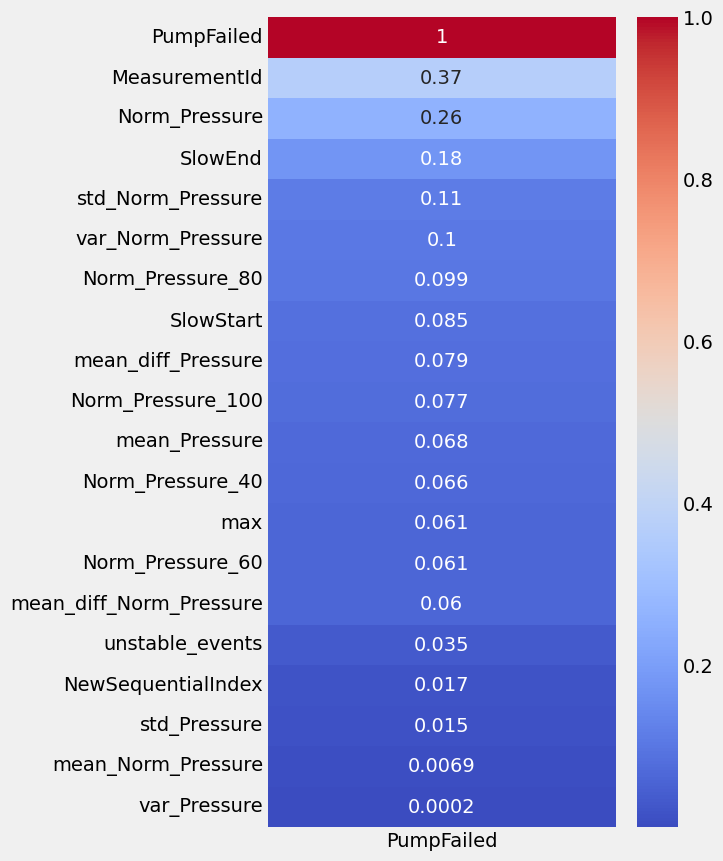

In [36]:
import seaborn as sns
corr_matrix = df_model.corr()

plt.figure(figsize=(5,10))  # adjust size to fit
sns.heatmap(abs(corr_matrix[["PumpFailed"]]).sort_values(by="PumpFailed", ascending=False), annot=True, cmap='coolwarm')

According to correlation matrix normalized pressure in first 20% of cycle is correlated to the model (Sorry named badly)

## Random Forrest feature importance

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
print(pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance')
)



                    Feature  Importance
1                   SlowEnd    0.028005
17          unstable_events    0.038780
5              std_Pressure    0.039409
3              var_Pressure    0.039650
4                       max    0.040612
2             mean_Pressure    0.043487
15         Norm_Pressure_80    0.048448
14         Norm_Pressure_60    0.049275
6        mean_diff_Pressure    0.049597
7        mean_Norm_Pressure    0.050676
16        Norm_Pressure_100    0.052109
10  mean_diff_Norm_Pressure    0.052422
8         var_Norm_Pressure    0.058991
9         std_Norm_Pressure    0.060984
11       NewSequentialIndex    0.065999
13         Norm_Pressure_40    0.066751
0                 SlowStart    0.068032
12            Norm_Pressure    0.146773


## XGBoost

In [52]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor


#cat_attribs = ['MachineId']

#full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_attribs)], remainder='passthrough')
#X_train = X_train.fillna(0)
#encoder = full_pipeline.fit(X_train)

#X_train = X_train.fillna(0)
#encoder = full_pipeline.fit(X_train_res)
#X_train = encoder.transform(X_train_res)
#X_test = encoder.transform(X_test)


#X_train = np.nan_to_num(X_train)
#X_test = np.nan_to_num(X_test)


In [53]:

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    verbosity =1
)
# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      3444
           1       0.49      0.69      0.57       416

    accuracy                           0.89      3860
   macro avg       0.73      0.80      0.75      3860
weighted avg       0.91      0.89      0.90      3860

Accuracy: 0.8893782383419689
Precision: 0.4905335628227194
Recall: 0.6850961538461539
F1 Score: 0.5717151454363089
ROC AUC Score: 0.799574790047351
Confusion Matrix:
[[3148  296]
 [ 131  285]]


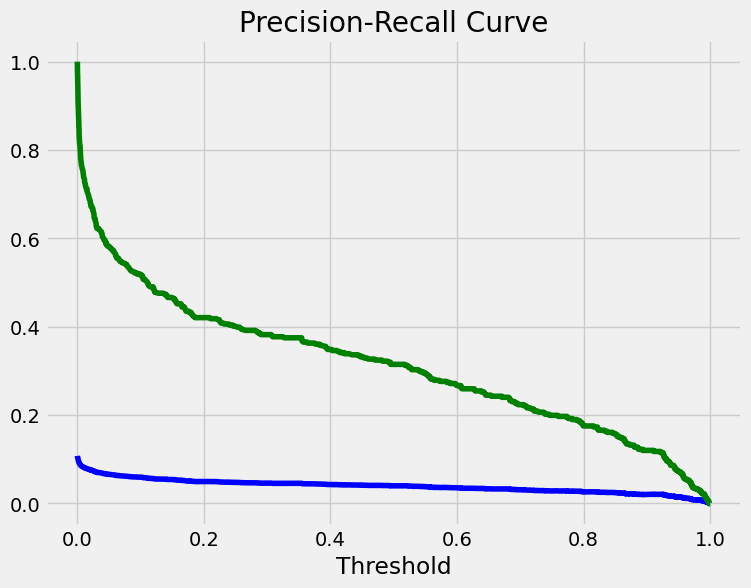

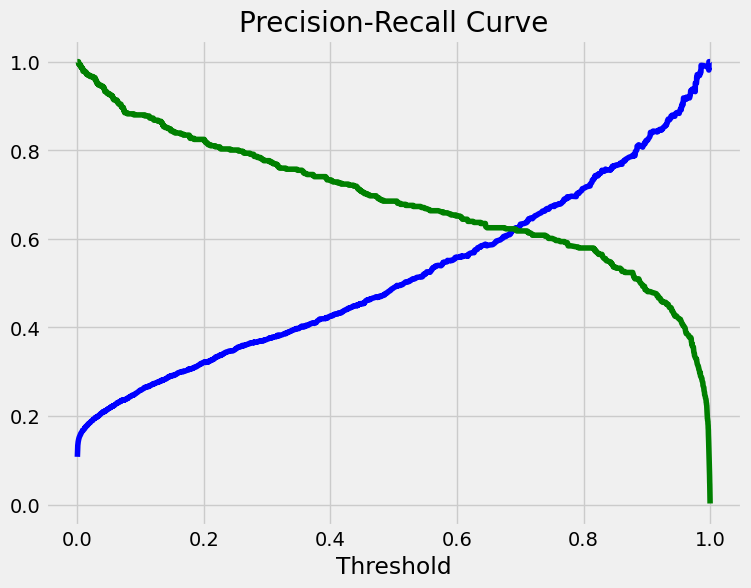

In [54]:
y_probs = model.predict_proba(X_test) 

y_probs_class1 = y_probs[:, 0]


precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_class1)

# plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.title("Precision-Recall Curve")
plt.show()

y_probs_class1 = y_probs[:, 1]


precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_class1)
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b-", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.title("Precision-Recall Curve")
plt.show()

Much more can be done: 
- Hyperparameters tunning 
- k-fold crossvalidation 
- better handling dataset imbalance 
- playing around with features 
- the cycles cut - maybe data with multi cycles should be deleted, since i don't know what correct label for them 
- Using timeseries for prediction